<a href="https://colab.research.google.com/github/oceam/agri-image/blob/main/codes/Calculate_cc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation use Machine learning

> 画像セグメンテーション用途 機械学習

# Calculate the Plant Canopy Cover 

> 植物キャノピーカバーの算出 

Haozhou Wang & Wei Guo  
2022.11.21

# Hidden Codes

> 隠しコード

All the codes used in this course are hidden here, you can use `course.xxxx()` to run some functions

> このコースで使用されるすべてのコードはここに隠されています。いくつかの関数を実行するために `course.xxxx()` を使用することができます。

In [2]:
# import packages
from google.colab import files

import os
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread

In [3]:
from skimage.filters import threshold_otsu
from skimage import morphology

import time
import sys
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from skimage import io, color

class Course:

    def __init__(self):
        pass

    ##################
    # 3 index values #
    ##################
    @staticmethod
    def ExG(img_np):
        img = img_np.astype(np.float32)
        R = img[:, :, 0]
        G = img[:, :, 1]
        B = img[:, :, 2]
        
        return 2 * G - R - B

    @staticmethod
    def ExR(img_np):
        img = img_np.astype(np.float32)
        R = img[:, :, 0]
        G = img[:, :, 1]
        B = img[:, :, 2]
        
        return 1.4 * R - G

    @staticmethod
    def NDI(img_np):
        img = img_np.astype(np.float32)
        R = img[:, :, 0]
        G = img[:, :, 1]
        B = img[:, :, 2]
        
        return (G - R) / (G + R + 0.0000000001)  # solve G=0 and R=0


    #########################
    # Otsu Threshold method #
    #########################
    @staticmethod
    def otsu(image):
        thresh = threshold_otsu(image)
        return image > thresh

    ######################
    # Calculate coverage #
    ######################
    @staticmethod
    def coverage(binary_img):
        h, w = binary_img.shape
        total = h * w
        
        true_num = np.sum(binary_img==True)
        
        return true_num / total

    @staticmethod
    def plant_index_otsu(img_list, figsize=None, dpi=300):
        img_num = len(img_list)
        if figsize is None:
            figsize = (4*img_num, 9)
        fig, ax = plt.subplots(3, img_num, figsize=figsize, dpi=300)

        if img_num == 1:
            ax = ax.reshape(3, 1)

        for i, test_img in enumerate(img_list):
            exg1 = course.ExG(test_img)
            exr1 = course.ExR(test_img)

            ex_GR1 = exg1 - exr1

            exg1_otsu = course.otsu(exg1)

            binary_GR1 = ex_GR1 > 0


            ax[0,i].set_title(f"Image {i+1}")

            ax[0,i].imshow(test_img)
            ax[0,i].set_xticks([])
            ax[0,i].set_yticks([])
            ax[0,i].set_xticklabels([])
            ax[0,i].set_yticklabels([])

            ax[1,i].set_title(f"{round(course.coverage(exg1_otsu)*100, 2)}%")
            ax[1,i].imshow(exg1_otsu, cmap="gray")
            ax[1,i].set_xticks([])
            ax[1,i].set_yticks([])
            ax[1,i].set_xticklabels([])
            ax[1,i].set_yticklabels([])
            ax[1,i].set_xlabel(f"ExG + Otsu")

            ax[2,i].set_title(f"{round(course.coverage(binary_GR1)*100, 2)}%")
            ax[2,i].imshow(binary_GR1, cmap="gray")
            ax[2,i].set_xlabel(f"ExG-ExR>0")
            ax[2,i].set_xticks([])
            ax[2,i].set_yticks([])
            ax[2,i].set_xticklabels([])
            ax[2,i].set_yticklabels([])

        plt.show()


    ########################
    # Supervised ML by CSV #
    ########################
    @staticmethod
    def expand_colorspace(img):
        # img is the ndarray from io.imread()
        (h, w, dimen) = img.shape
        
        if dimen == 4: # exist alpha layer (RGBA)
            img = img[:,:, 0:3]
            dimen = 3
            
        rgb = img.reshape(h * w, dimen)
        lab = color.rgb2lab(img).reshape(h * w, dimen)
        hsv = color.rgb2hsv(img).reshape(h * w, dimen)
        
        exp_img = np.concatenate((rgb, lab, hsv), axis=1)
        
        return exp_img
        
    @staticmethod
    def training_data_from_easypcc_csv(csv_path, crop_name='Crop'):
        csv_data = pd.read_csv(csv_path)
        px_num = len(csv_data)
        
        # convert R G B vertical list to skimage.color.pixels
        csv_rgb = np.stack([csv_data[['R']], csv_data[['G']], csv_data[['B']]], axis=2)
        # convert in python way, incase JS not get same results
        lab = color.rgb2lab(csv_rgb).reshape(px_num, 3)
        hsv = color.rgb2hsv(csv_rgb).reshape(px_num, 3)
        # merge to list
        train_data = np.concatenate((csv_data[['R', 'G', 'B']], lab, hsv), axis=1)
        
        train_kind = np.zeros((px_num, 1))
        train_kind[csv_data['Class'] == crop_name, :] = 1
        
        return train_data, train_kind

    @staticmethod   
    def train_model(train_data, train_kind, classifier="CART"):
        # classifier = ["CART", "SVM", "RF"]
        t0 = time.time()
        if classifier == "CART":
            clf = DecisionTreeClassifier(max_depth=20)
        elif classifier == "SVM":
            clf = LinearSVC()
        elif classifier == "RF":
            clf = RandomForestClassifier()
        elif classifier == "GDBT":
            clf = GradientBoostingClassifier()
            
        clf = clf.fit(train_data, train_kind)
        t1 = time.time()
        
        print(f'|-- Training model time cost={int(t1-t0)}s')
        return clf

    def predict_model(self, clf_img, model):
        (h, w, dimen) = clf_img.shape
        exp_clf_img = self.expand_colorspace(clf_img)
        pred_result = model.predict(exp_clf_img).reshape(h, w)
        return pred_result
 
    def apply_model(self, clf_img, model):
        t0 = time.time()
        (h, w, dimen) = clf_img.shape
        if h * w >= 1600 * 1600:  # slice picture to save RAM
            slice_num = np.ceil(w * h / (1600 * 1600)).astype(np.int32)
            break_points = np.linspace(0, h, num=slice_num).astype(np.int32)
            line_st = break_points[:-1]
            line_ed = break_points[1:]
        else:
            line_st = [0]
            line_ed = [h]
        
        pred_result = np.empty((0, w))
        i = 0
        for st, ed in zip(line_st, line_ed):
            clf_result = self.predict_model(clf_img[st:ed, :], model)
            pred_result = np.vstack((pred_result, clf_result))
            
            percent = round((i+1) / len(line_st) * 100, 2)
            print('\r|' + '='*round(percent/2) + '>'+ ' '*round(50-percent/2) + '|' + str(percent) + '%', end="")
            i += 1
        t1 = time.time()
        print(f'| Cost={int(t1-t0)}s')
        return pred_result

    @staticmethod
    def save_result(pred_result, img_save_name, color_list):
        color_list = np.array(color_list)/255
        cmap_cf = ListedColormap(color_list, name='colorfriendly')
        plt.imsave(img_save_name, pred_result, cmap=cmap_cf)

    @staticmethod
    def denoise(image, min_obj_size=100, area_thresh=25):
        cleaned1 = morphology.remove_small_objects(image==1, min_size=min_obj_size)
        cleaned1 = morphology.remove_small_holes(cleaned1, area_threshold=area_thresh)

        return cleaned1

    ###############
    # SML wrapper #
    ###############
    def supervise_machine_learning(self, uav_image, uav_train, denoise="default", save=None):
        test1 = imread(uav_image)
        train_data, train_kind = self.training_data_from_easypcc_csv(uav_train)
        model = self.train_model(train_data, train_kind, classifier="CART")
        result = self.apply_model(test1, model)
        if denoise == "default":
            result_clean = self.denoise(result)
        else:
            result_clean = self.denoise(result, denoise[0], denoise[1])

        fig, ax = plt.subplots(1, 3, figsize=(6,9), dpi=300)
        ax[0].imshow(test1)
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_xticklabels([])
        ax[0].set_yticklabels([])
        ax[0].set_xlabel("Original Image")

        ax[1].set_title(f"{round(self.coverage(result)*100, 2)}%")
        ax[1].imshow(result, cmap="gray")
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_xticklabels([])
        ax[1].set_yticklabels([])
        ax[1].set_xlabel("Classified by ML")

        ax[2].set_title(f"{round(self.coverage(result_clean)*100, 2)}%")
        ax[2].imshow(result_clean, cmap="gray")
        ax[2].set_xticks([])
        ax[2].set_yticks([])
        ax[2].set_xticklabels([])
        ax[2].set_yticklabels([])
        ax[2].set_xlabel("Denoised")
        if save is not None:
            os.makedirs(save, exist_ok=True)
            plt.tight_layout()
            plt.savefig(f"{save}/result_{uav_image.split('/')[-1]}")
            plt.close()
        else:
            plt.show()
        
        return round(self.coverage(result)*100, 2), round(self.coverage(result_clean)*100, 2)
        

course = Course()

# Section 0: Data Preparation

> 第0項 データの準備

Download dataset from google drive link:

> データセットをgoogle driveのリンクからダウンロードする。

In [4]:
# download file from google drive
# file link: https://drive.google.com/file/d/1rlMmWCpSsZ94-t50IRM6iwvuIdF6e-Ak/view
# download link(when you click download): https://drive.google.com/u/1/uc?id=1rlMmWCpSsZ94-t50IRM6iwvuIdF6e-Ak&export=download
# use id from download link
!gdown --id 1rlMmWCpSsZ94-t50IRM6iwvuIdF6e-Ak

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1rlMmWCpSsZ94-t50IRM6iwvuIdF6e-Ak
To: /content/ccexample.zip
100% 20.1M/20.1M [00:00<00:00, 59.3MB/s]


Then unzip that example data by:

> そして、その例のデータをbyで解凍してください。

In [5]:
!unzip ccexample.zip  # change the example.zip to any other zip file

Archive:  ccexample.zip
   creating: ccexample/broccoli/
  inflating: ccexample/broccoli/200421_11_DJI_0402.csv  
  inflating: ccexample/broccoli/200421_11_DJI_0402.JPG  
  inflating: ccexample/broccoli/200422_11_DJI_0206.csv  
  inflating: ccexample/broccoli/200422_11_DJI_0206.JPG  
  inflating: ccexample/broccoli/200427_11_DJI_0654.csv  
  inflating: ccexample/broccoli/200427_11_DJI_0654.JPG  
  inflating: ccexample/broccoli/200430_11_DJI_0413.csv  
  inflating: ccexample/broccoli/200430_11_DJI_0413.JPG  
  inflating: ccexample/broccoli/200508_11_DJI_0400.csv  
  inflating: ccexample/broccoli/200508_11_DJI_0400.JPG  
 extracting: ccexample/course.py     
   creating: ccexample/imgs/
  inflating: ccexample/imgs/Meyer2008.png  
  inflating: ccexample/imgs/paper.png  
  inflating: ccexample/imgs/test1.jpg  
  inflating: ccexample/imgs/test2.jpg  


Here is the all images used in this course (UAV flight at 15m)

> 本講座で使用した全画像はこちら（15mでのUAV飛行）。

![](https://www.dropbox.com/s/e2ubk1sezraa2o7/ccexample.png?dl=1)

# Section 1: Background

> 第1章：背景

How to estimate plant coverage from images

> 画像から植物被覆率を推定する方法

Images are consisted by large amount of pixels:

> 画像は大量の画素で構成されています。

![](https://www.dropbox.com/s/v83fxxgaeh6cigi/colab_20210629163507.gif?dl=1)

If we can judge each pixel whether a plant pixel or soil pixel

> 各画素が植物の画素か土壌の画素かを判断することができれば

$$ \frac{\text{number of plants}}{\text{number of all pixels}} = \frac{\text{plant area}}{\text{full area}} = \text{plant coverage}$$

### How can we judge pixel classes?

> 画素クラスはどのように判断すればよいのでしょうか。

One way is judge one by one manually (Paint to different pure colors for easier identify).

> 1つ1つ手作業で判定する方法もあります（識別しやすいように異なる純色に塗る）。

![](https://www.dropbox.com/s/xmvjd8wn6ij4gw5/colab_20210629164607.gif?dl=1)


It is a necessary step when prepare "ground truth" for computer vision experiments

> コンピュータビジョンの実験に必要な「グランドトゥルース」を準備する際に必要なステップです。

---

But previous is very tedious, do we have any automatic way?

> でも、前回はとても面倒なので、自動でできる方法はないでしょうか？

The answer is true, because in computer, the colors is actually a group of numbers

> コンピュータでは、色は実際には数字の集まりですから、答えは正しいのです

![](https://www.dropbox.com/s/yxsz9h31j5fnhjg/colab_20210629164956.png?dl=1)

We can use three-primary colours (red, green, and blue) and its intensity to represent all kinds of visuable colors.

> 赤、緑、青の3原色とその強度を用いて、目に見えるあらゆる色を表現することができるのです。

For example, we have a image like this:

> 例えば、こんな画像があります。


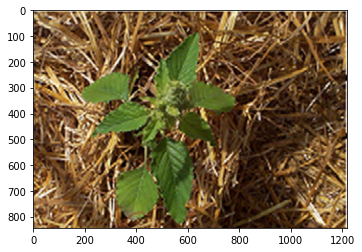

In [6]:
# read images into code
paper = imread('ccexample/imgs/paper.png')
paper = paper[:, :, 0:3]

# display image
plt.imshow(paper)

what is actually saved in the computer?

> 実際にパソコンに保存されているものは何ですか？

In [7]:
paper.shape

(844, 1218, 3)

The `.shape` tells the size of this image, it is 844 pixel height, 1218 pixel width, and 3 channels with RGB.

> `.shape`はこの画像の大きさを示しており、縦844ピクセル、横1218ピクセル、RGBの3チャンネルとなっています。

Here is the code to check the values of the left upper corner pixel:

> 以下は、左上隅のピクセルの値をチェックするコードです。

In [8]:
paper[0,0,:]

array([255, 255, 254], dtype=uint8)

It means, Red=255, Green=255, and Blue=254.

> つまり、赤＝255、緑＝255、青＝254ということです。

# Section 2: Classify by simple values

> 第2項 単純な値で分類する

### Classify by a single color channel

> 単一カラーチャンネルによる分類

In the following figure, we can see the leaves are green and background are yellow

> 次の図では、葉が緑、背景が黄色であることがわかります。


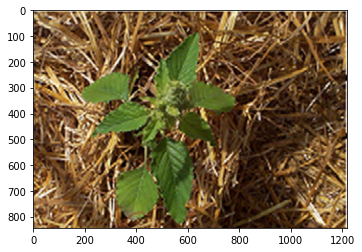

In [9]:
plt.imshow(paper)

And according to this color table, we can see the yellow color both have very high R & G values, but the green color have low R and hight G values.

> そして、このカラーテーブルによると、黄色は両方ともRとGの値が非常に高いが、緑色はRが低く、Gの値が高いことがわかる。

![](https://www.dropbox.com/s/ntkgooo8uj55g0u/colab_20210629171807.png?dl=1)

So we can define a threshold, to say all R values < 100 are green leaves, otherwise is background

> そこで、R値が100未満のものは緑の葉、それ以外は背景とする閾値を定義することができる。

The following code `paper[:,:,0]` means: choose all height (the first `:`), and all width (the second `:`), and only the first layer (The third `0`) in color channel (red color)

> 次のコード `paper[:,:,0]` は、高さ (最初の `:`) と幅 (2番目の `:`) をすべて選択し、最初のレイヤー (3番目の `0`) のみをカラーチャンネル (赤色) で表示することを意味します。

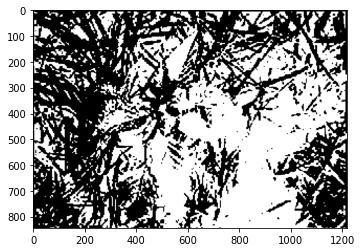

In [10]:
plt.imshow(paper[:,:,0] < 100, cmap="gray")

The white color indicate the pixels R values < 100.

> 白色はR値＜100の画素を示す。

But it seems bad result.

> しかし、結果は芳しくないようです。

Because the color interactions are very complecated, using simple green channel can not distinuish very well.

> 色の相互作用は非常に複雑であるため、単純なグリーンチャンネルを使用してもあまり区別することができません。

### Classify by color index values

> カラーインデックス値で分類する

In the paper of "[Verification of color vegetation indices for automated crop imaging applications](https://doi.org/10.1016/j.compag.2008.03.009)
", Meyer proposed three index calculated from RGB values: `NDI`, `ExG`, and `ExR`

> "[自動作物画像処理アプリケーションのためのカラー植生指標の検証](https://doi.org/10.1016/j.compag.2008.03.009)"の論文で、Meyerは、RGB値から計算される3つのインデックスを提案した。`NDI`, `ExG`, `ExR`です。

![](https://www.dropbox.com/s/4dyiju0vg0bnmkz/colab_20210629173055.png?dl=1)

By using three values, it strength the differences between leaves and backgrounds.

> 3つの値を使うことで、葉と背景の違いを強調しています。

Meanwhile, instead of manual given a value (e.g. 100 in previous cases, it used an automatic method: Otsu Threshold)

> 一方、手動で値を与えるのではなく（例：従来は100）、自動的な方法：大津式閾値を使用した

<p><a href="https://commons.wikimedia.org/wiki/File:Otsu%27s_Method_Visualization.gif#/media/File:Otsu's_Method_Visualization.gif"><img src="https://upload.wikimedia.org/wikipedia/commons/3/34/Otsu%27s_Method_Visualization.gif" alt="Otsu's Method Visualization.gif"></a></p>

Let us recurrent this experiment:

> この実験を再現してみましょう。

**Show the strength results like paper**

> 強度結果を紙のように表示する


In [11]:
exg_p = course.ExG(paper)
exr_p = course.ExR(paper)
ndi_p = course.NDI(paper)

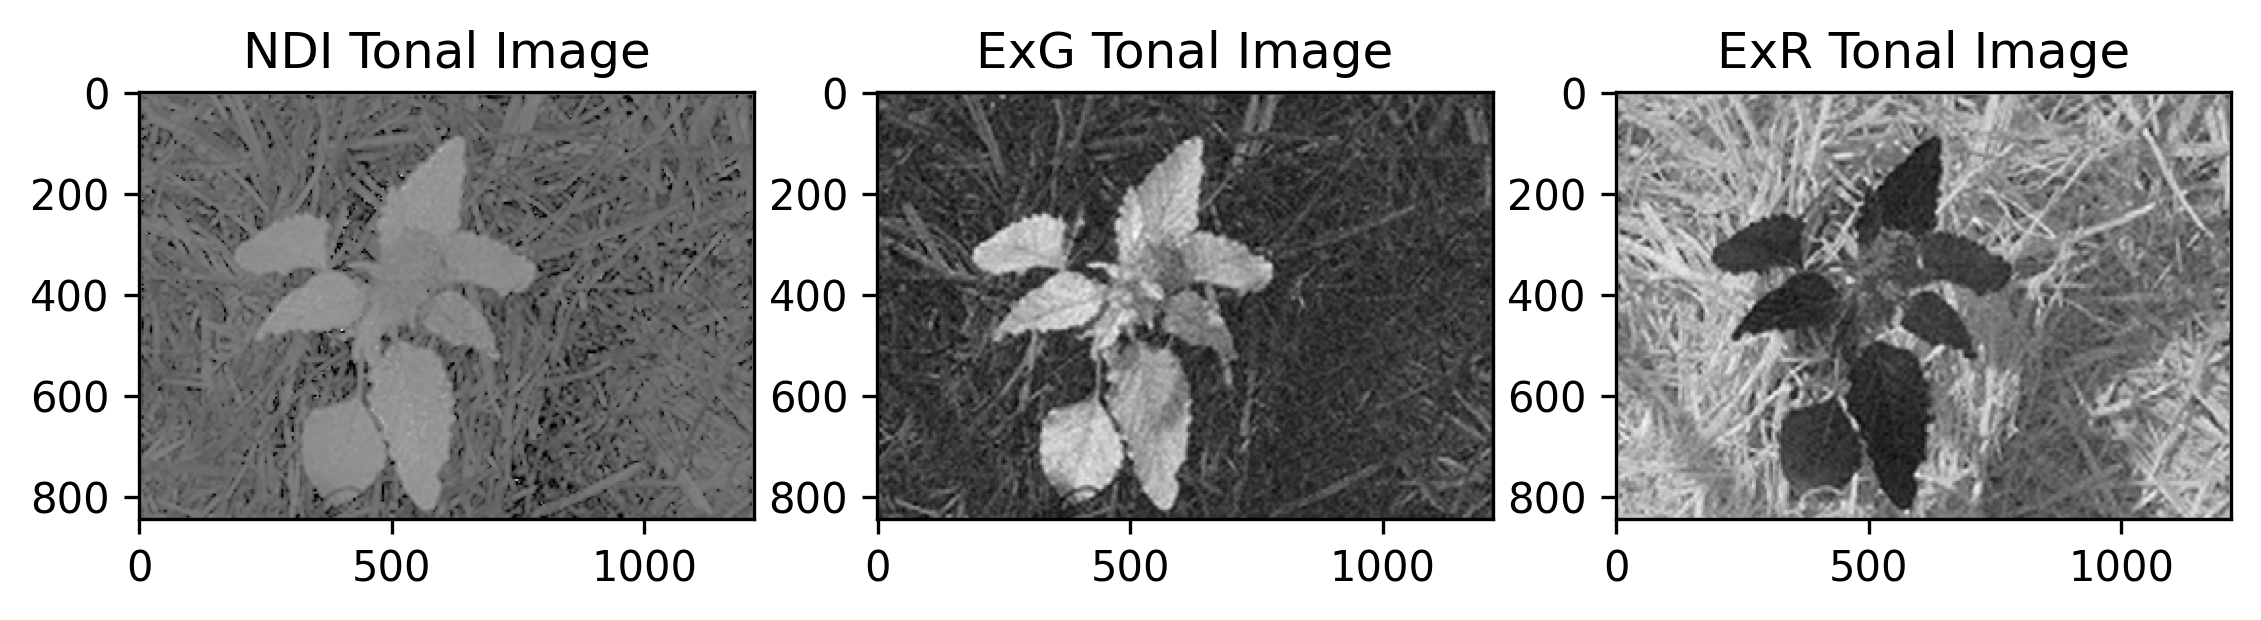

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=300)

ax[0].set_title("NDI Tonal Image")
ax[0].imshow(ndi_p, cmap="gray")

ax[1].set_title("ExG Tonal Image")
ax[1].imshow(exg_p, cmap="gray")

ax[2].set_title("ExR Tonal Image")
ax[2].imshow(exr_p, cmap="gray")

plt.show()

**Change to a black and white 2 class figure**

> 白黒2クラスフィギュアへの変更

In [13]:
ndi_p_otsu = course.otsu(ndi_p)
exg_p_otsu = course.otsu(exg_p)

ExG_ExR_p = exg_p - exr_p
binary_GR_p = ExG_ExR_p > 0

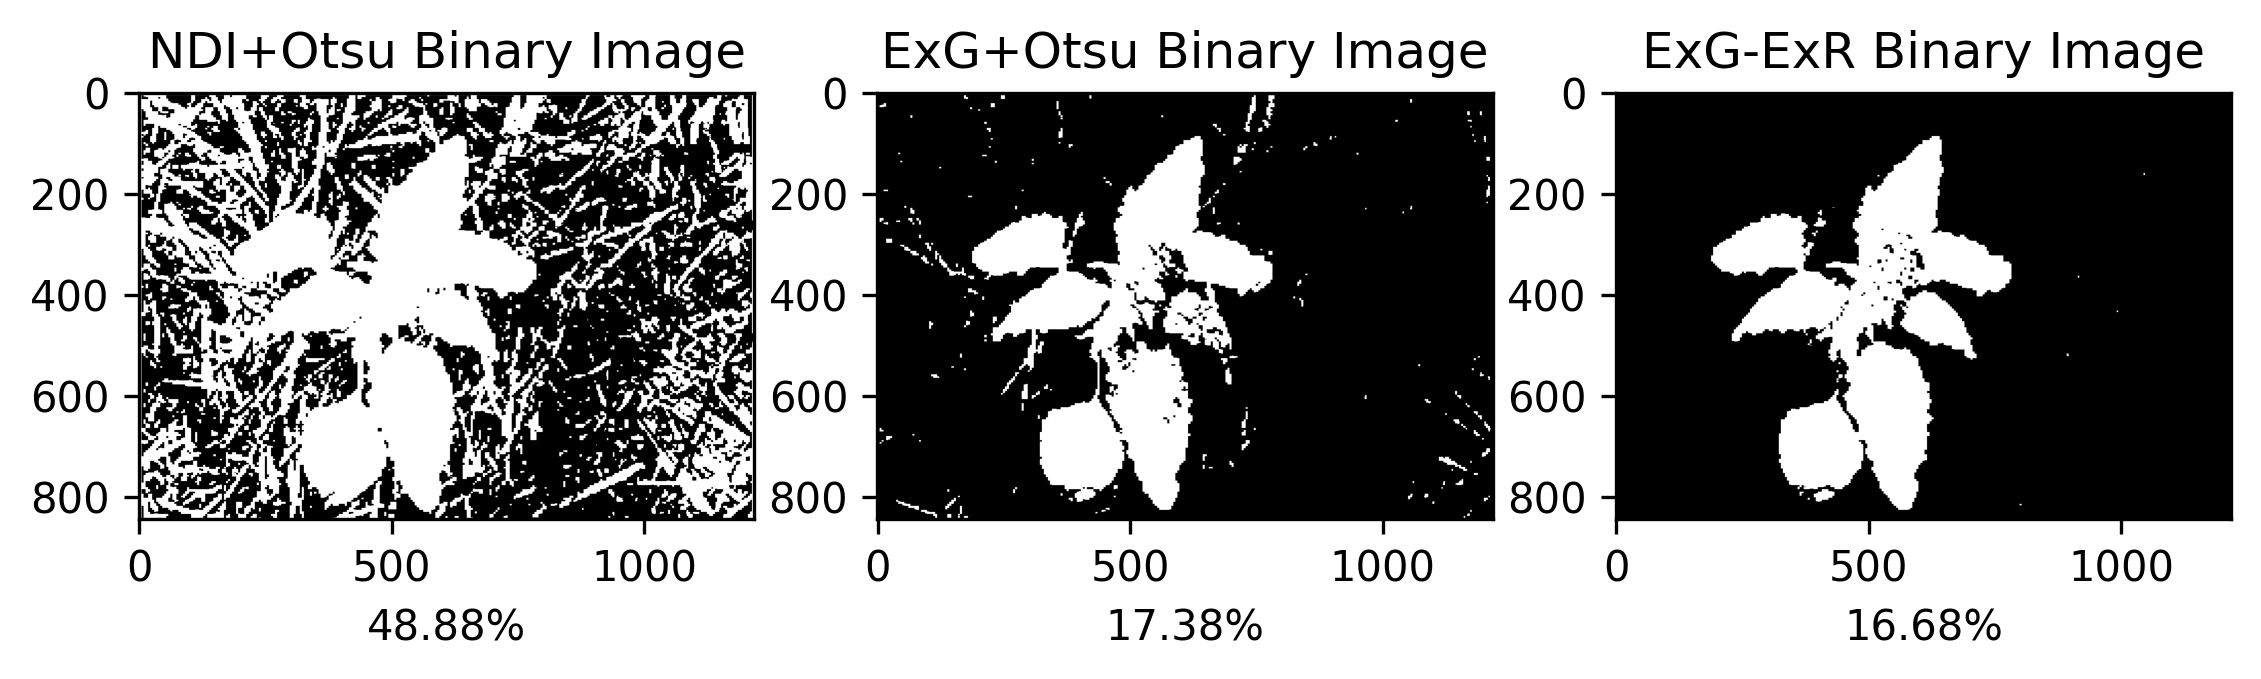

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=300)

ax[0].set_title("NDI+Otsu Binary Image")
ax[0].imshow(ndi_p_otsu, cmap="gray")
ax[0].set_xlabel(f"{round(course.coverage(ndi_p_otsu)*100, 2)}%")

ax[1].set_title("ExG+Otsu Binary Image")
ax[1].imshow(exg_p_otsu, cmap="gray")
ax[1].set_xlabel(f"{round(course.coverage(exg_p_otsu)*100, 2)}%")

ax[2].set_title("ExG-ExR Binary Image")
ax[2].imshow(binary_GR_p, cmap="gray")
ax[2].set_xlabel(f"{round(course.coverage(binary_GR_p)*100, 2)}%")

plt.show()

### Practice on simple paddy practices

> 簡易水田の実践

Here we have two paddy images

> ここでは、2つの水田を撮影しています。

In [15]:
# read paddy data
test1 = imread('ccexample/imgs/test1.jpg')
test2 = imread('ccexample/imgs/test2.jpg')

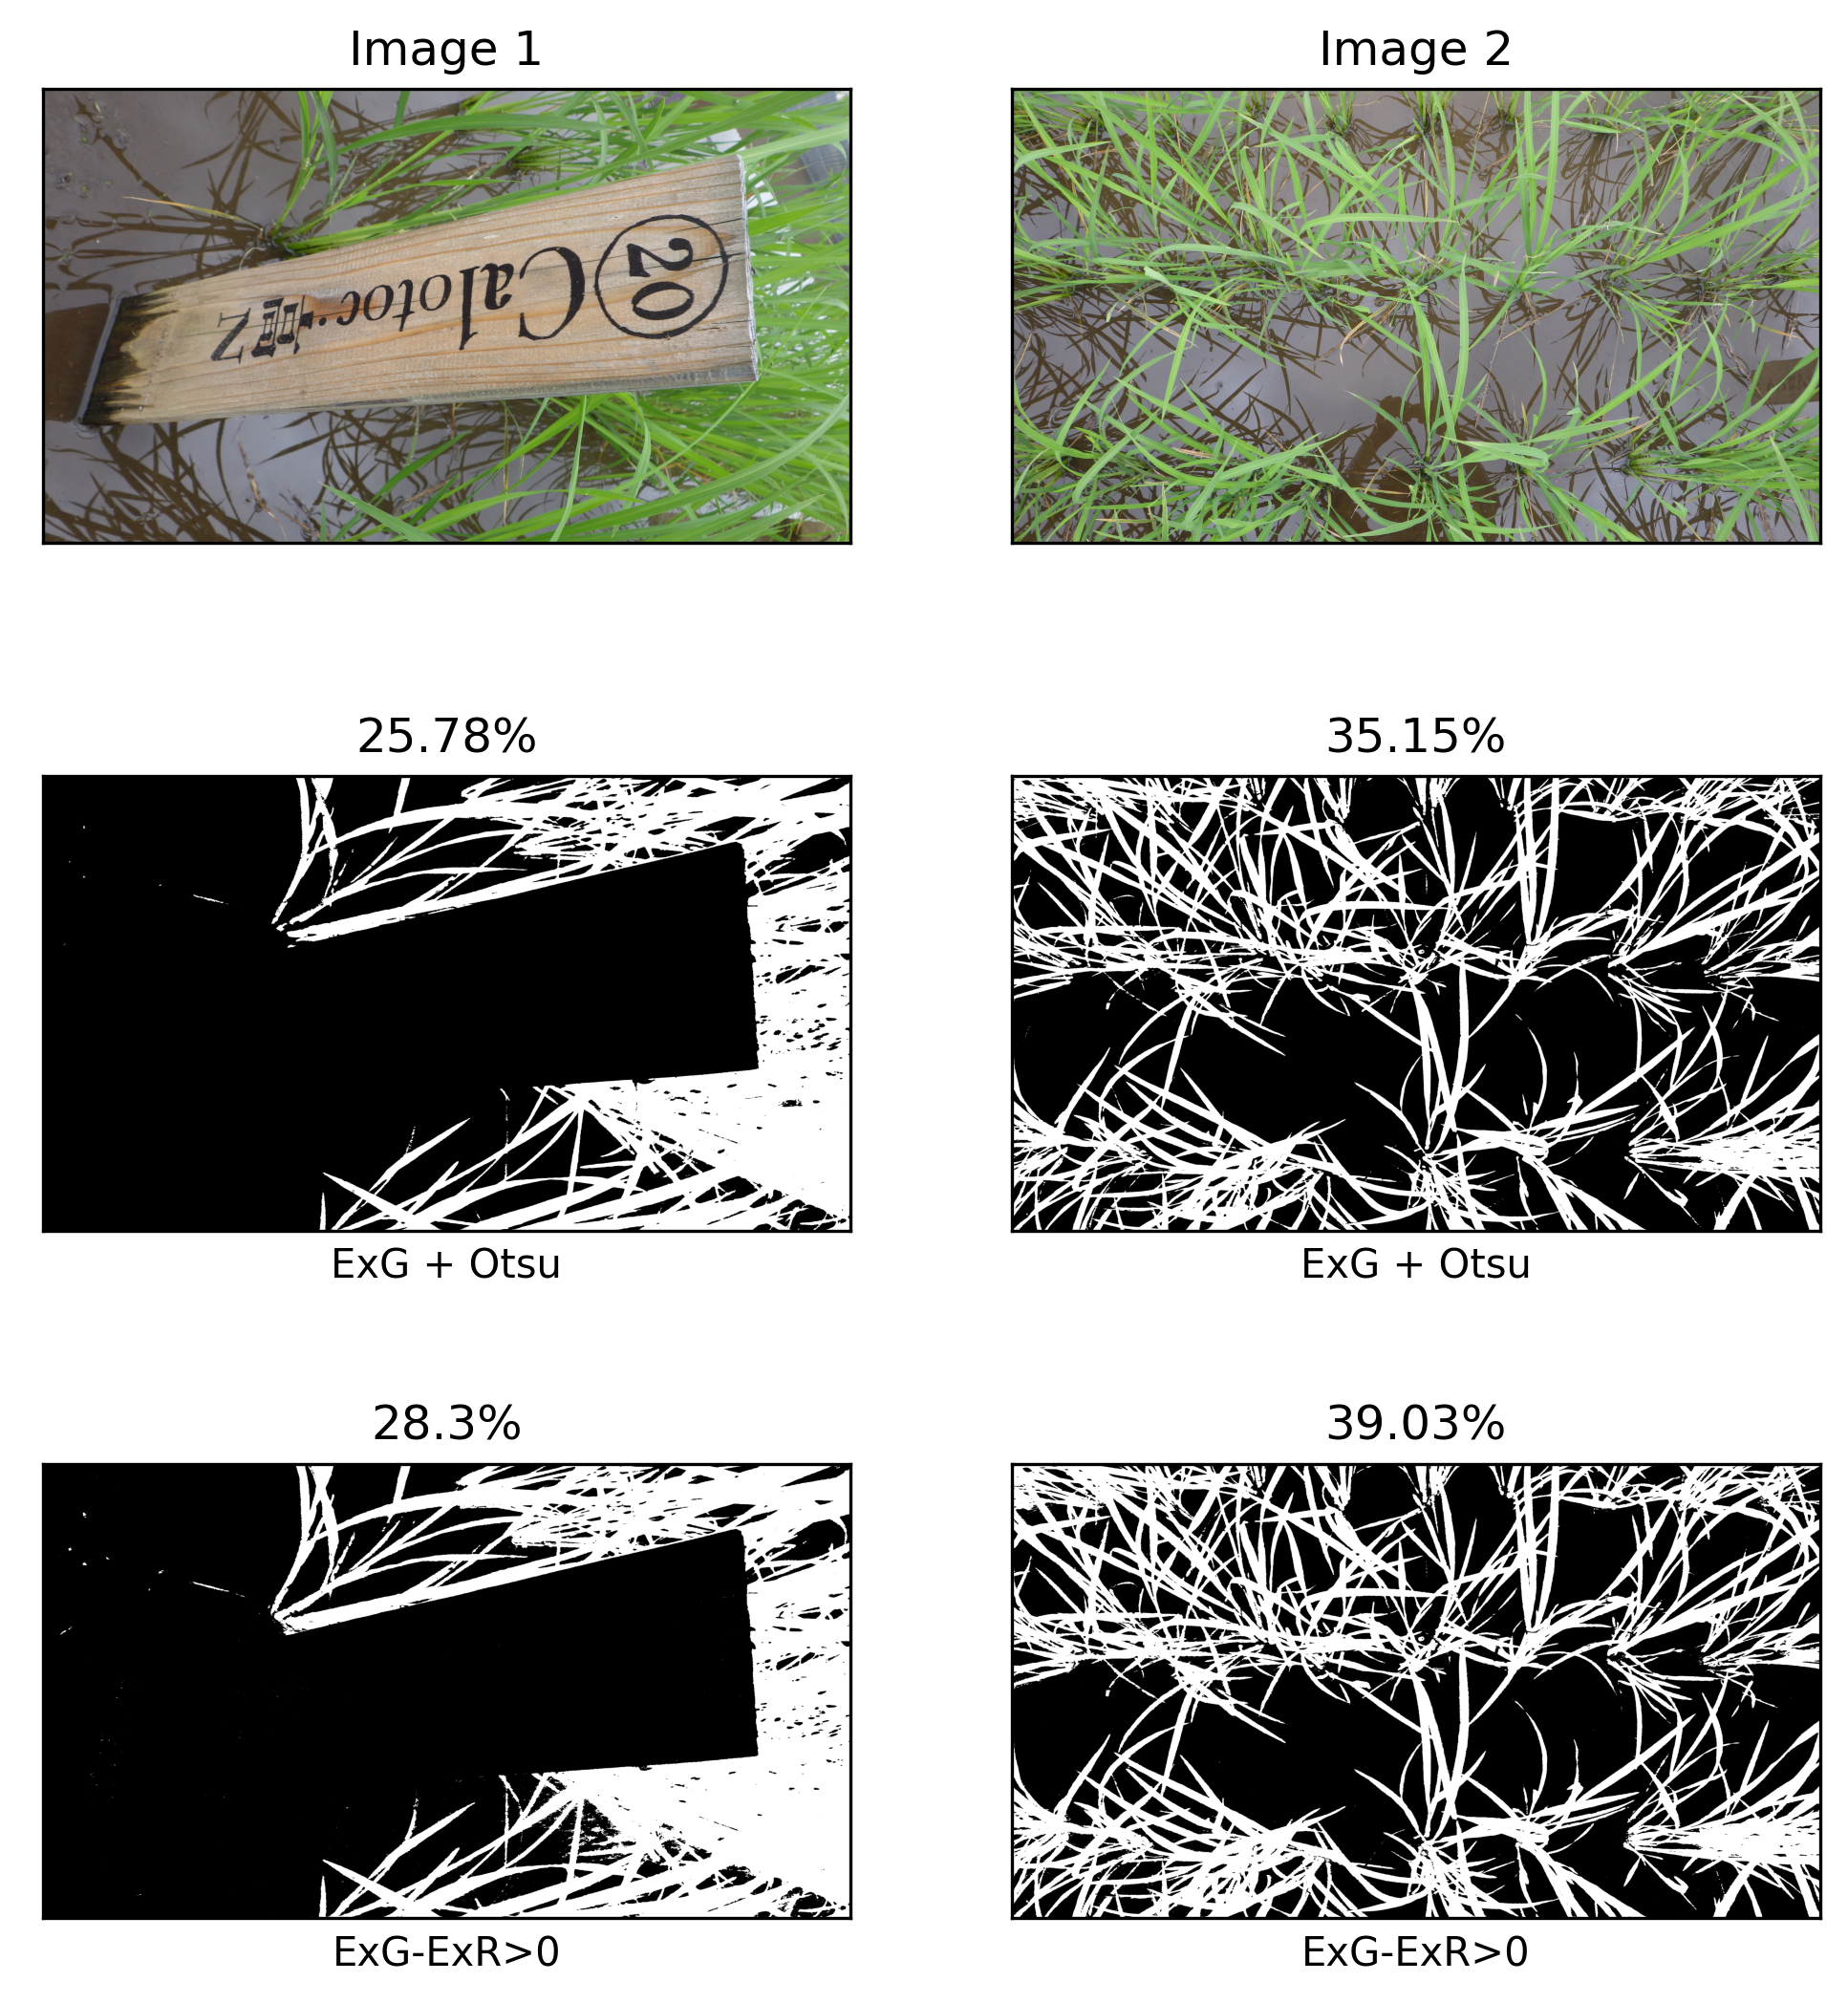

In [16]:
course.plant_index_otsu([test1, test2])

### Test on UAV image

> UAV画像でのテスト

Please use the following code, upload two UAV images into Colab:

> 以下のコードを使用して、2つのUAV画像をColabにアップロードしてください。

In [ ]:
uploaded = files.upload()

Then change the file name in the follwoing code by two images just uploaded:

> 次に、以下のコードのファイル名を、先ほどアップロードした2つの画像に変更します。

In [ ]:
your_uav1 = imread('200421_11_DJI_0402.JPG')   # <- change the string here for image one
your_uav2 = imread('200422_11_DJI_0206.JPG')   # <- change the string here for image two

Run the following code to see the results!

> 次のコードを実行して、結果を確認してください

In [ ]:
course.plant_index_otsu([your_uav1, your_uav2])

How is your results look like? Do they performs perfectly?

> 結果はどのように見えますか？完璧に動作していますか？

Don't worry if your results are not perfect, we have solutions for dealing with some complex images.

> 複雑な画像を扱うためのソリューションも用意していますので、結果が完璧でない場合もご安心ください。

### Problems when dealing with complex background

> 複雑な背景を扱う場合の問題点

Let us test on our broccoli data

> ブロッコリーのデータでテストしてみましょう

In [17]:
broccoli1 = imread("ccexample/broccoli/200421_11_DJI_0402.JPG")
broccoli2 = imread("ccexample/broccoli/200430_11_DJI_0413.JPG")
broccoli3 = imread("ccexample/broccoli/200508_11_DJI_0400.JPG")

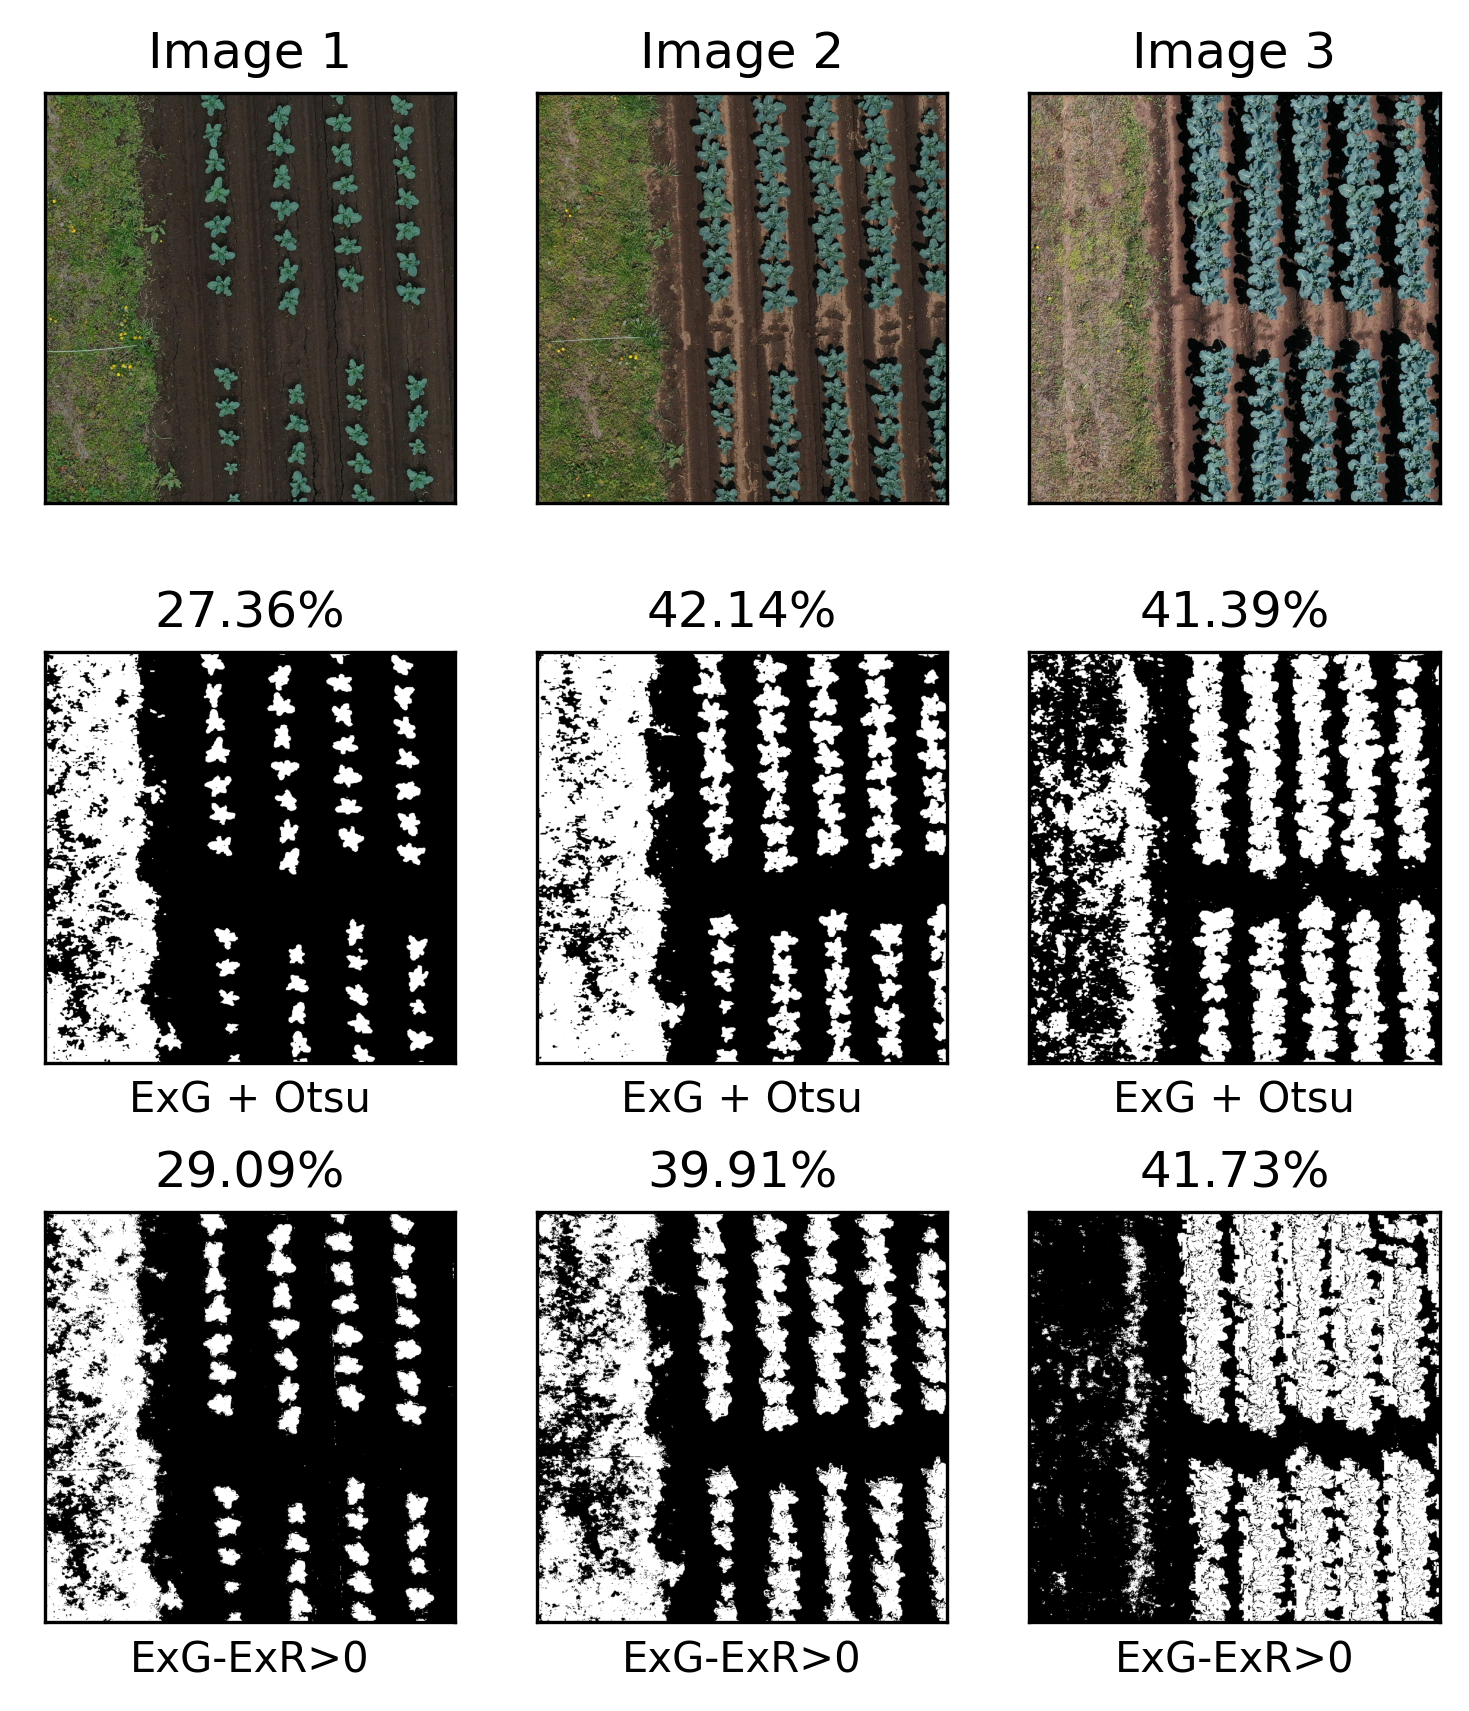

In [18]:
course.plant_index_otsu([broccoli1, broccoli2, broccoli3], figsize=(6,7))

The broccoli part seems acceptable, but the some weeds are also distinguished as the plant part, what if we do not want those weeds be counted in?

> ブロッコリーの部分は問題なさそうですが、雑草も植物部分として区別されているので、その雑草はカウントしないでほしいという場合はどうすればいいのでしょうか？

# Section 3: Classify by supervised machine learning

> 第3項 教師付き機械学習による分類

The supervised machine learning means

> 教師あり機械学習とは

Human prepare the some examples to machine, the machine itself will try to learn the regulation behind the examples that you give.

> 人間がいくつかの例を用意すると、機械はその例の背後にある規則を学習しようとします。

Here is the main steps for classifying images:

> ここでは、画像を分類するための主な手順を説明します。

1. Manual draw some parts of foreground (plants) and backgrounds (sold and weeds)  
    > 前景（植物）と背景（売られているもの、雑草）の一部を手動で描画する。    

    *Use `collectTrainJS_v2` tool in the folder*   
    > *フォルダ内の `collectTrainJS_v2` ツールを使用*。
1. Use those data to train models
    > これらのデータを使ってモデルを学習させる
1. Apply the trained models to images
    > 学習したモデルを画像に適用する
1. Denoise
    > ノイズ除去
1. Calculate the coverage
    > カバレッジを計算する


### Step 1: Draw training data (examples for machine) by `collectTrainJS_v2`

> Step 1: `collectTrainJS_v2` により学習データ (機械学習用の例) を作成する。

You can using the following tool, to prepare the foreground and background training data.

> フォアグラウンドとバックグラウンドの学習データを準備するために、以下のツールを使用することができます。

1. Download the image file to your local machine 

    > イメージファイルをローカルマシンにダウンロードする  

    <img src="https://drive.google.com/uc?id=1tGH85g7U0UqwNu4XR9GzohIDvCaTAR3e" alt="Google Drive Image" />

2. Run the following code, and drop the downloaded image file:

    > 以下のコードを実行し、ダウンロードした画像ファイルをドロップしてください。 

    <img src="https://drive.google.com/uc?id=1UVscGa8MZJ4y7Q2yMPkwNrTJVzE8cMpg" alt="Google Drive Image" />


3. Draw the foreground and background respectively

   > 前景と背景をそれぞれ描画する. 

   <img src="https://drive.google.com/uc?id=1_GnmkZfdMLJGBWy3HgfihH5VSiKUv3Cw" alt="Google Drive Image" />

   Examples for broccoli:    

   > ブロッコリーの例   

|   | example 1 | example 2|  
|---| ---       |  ---     |  
| foreground  | <img src="https://www.dropbox.com/s/5gvjsiyrmwnh0d2/colab_20210629144543.png?dl=1" height="500"/> | <img src="https://www.dropbox.com/s/xvbvpx448ksrbmk/colab_20210629155919.png?dl=1" height="500" />|   
| background. | <img src="https://www.dropbox.com/s/2f3uzb00crozoa6/colab_20210629144750.png?dl=1" height="500"/> | <img src="https://www.dropbox.com/s/rd973i3vycdttec/colab_20210629160247.png?dl=1" height="500"/> |


4. Save the result `tranData_2class.csv` to local disk, and then upload to the colab files.

    > 結果 `tranData_2class.csv` をローカルディスクに保存し、colab ファイルにアップロードする。   

    <img src="https://drive.google.com/uc?id=15vIh5U_xMWTRFX7X1tPoVuG-KV5eGe_E" alt="Google Drive Image" />

    We already provide a pre-labeled file, you can use this directly, or upload your own csv file.    

    >  すでにラベル付けされたファイルを提供していますので、これをそのまま使うこともできますし、ご自分のcsvファイルをアップロードすることもできます。

In [19]:
%%html
<script src="https://cdn.jsdelivr.net/npm/jquery@3.2.1/dist/jquery.min.js"></script>
<script src="https://cdn.jsdelivr.net/gh/oceam/agri-image/codes/easypcc_colab_js/color.js"></script>
<link type="text/css" href="https://cdn.jsdelivr.net/gh/oceam/agri-image/codes/easypcc_colab_js/base.css" rel="stylesheet" />
<script type="text/javascript" src="https://cdn.jsdelivr.net/gh/oceam/agri-image/codes/easypcc_colab_js/filePicker.js"></script>
<script type="text/javascript" src="https://cdn.jsdelivr.net/gh/oceam/agri-image/codes/easypcc_colab_js/trainingData.js"></script>

<!-- <canvas id="renderCanvas" touch-action="none" width="1280px" height="720px">
</canvas> -->
<h6>Rerun to refresh. Left click to drag, right click to draw, scroll to zoom, click the classes to change annotations.</h6>
<div id="files"></div>
<div id="classes"></div>
<div id="canvasArea" height="720px"></div>
<div id="control"></div>
<!-- <canvas id="renderCanvas" touch-action="none" width="1280px" height="720px" style="z-index=-1"></canvas>  -->

<script>
    google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
</script>

After drawing training data, upload the csv file to colab

> 学習データを描画した後、csvファイルをcolabにアップロードする

### Step 1.5: Load csv data into Colab

> ステップ1.5：csvデータをColabに読み込む

In [20]:
train_csv = "ccexample/broccoli/200508_11_DJI_0400.csv"

In [21]:
train_data, train_kind = course.training_data_from_easypcc_csv(train_csv)

### Step 2: train model

In [22]:
model = course.train_model(train_data, train_kind, classifier="CART")

|-- Training model time cost=0s


### Step 3: apply model

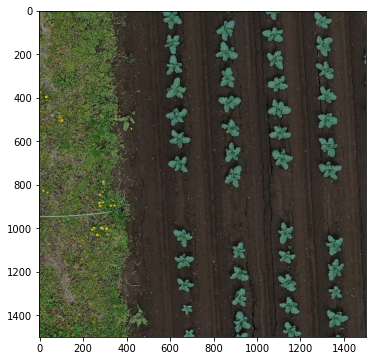

In [23]:
test1 = imread('ccexample/broccoli/200421_11_DJI_0402.JPG')
plt.figure(figsize = (6,6))
plt.imshow(test1)

|==================================================>|100.0%| Cost=4s


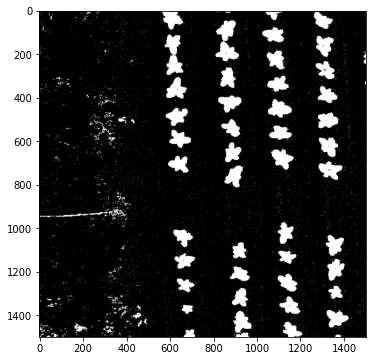

In [24]:
result = course.apply_model(test1, model)
plt.figure(figsize = (6,6))
plt.imshow(result, cmap="gray")

### Step 4: denoise

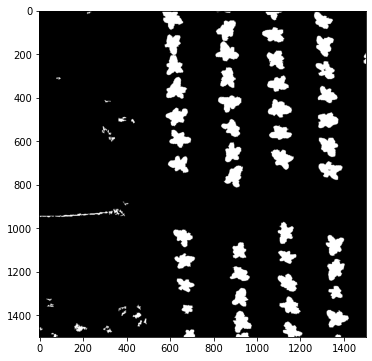

In [25]:
result_clean = course.denoise(result)
plt.figure(figsize = (6,6))
plt.imshow(result_clean, cmap="gray")

### Step 4: calculate the coverage

In [26]:
course.coverage(result)

0.10047866666666666

In [27]:
course.coverage(result_clean)

0.09157644444444445

### Step 5: merged together


|-- Training model time cost=0s
|==================================================>|100.0%| Cost=1s


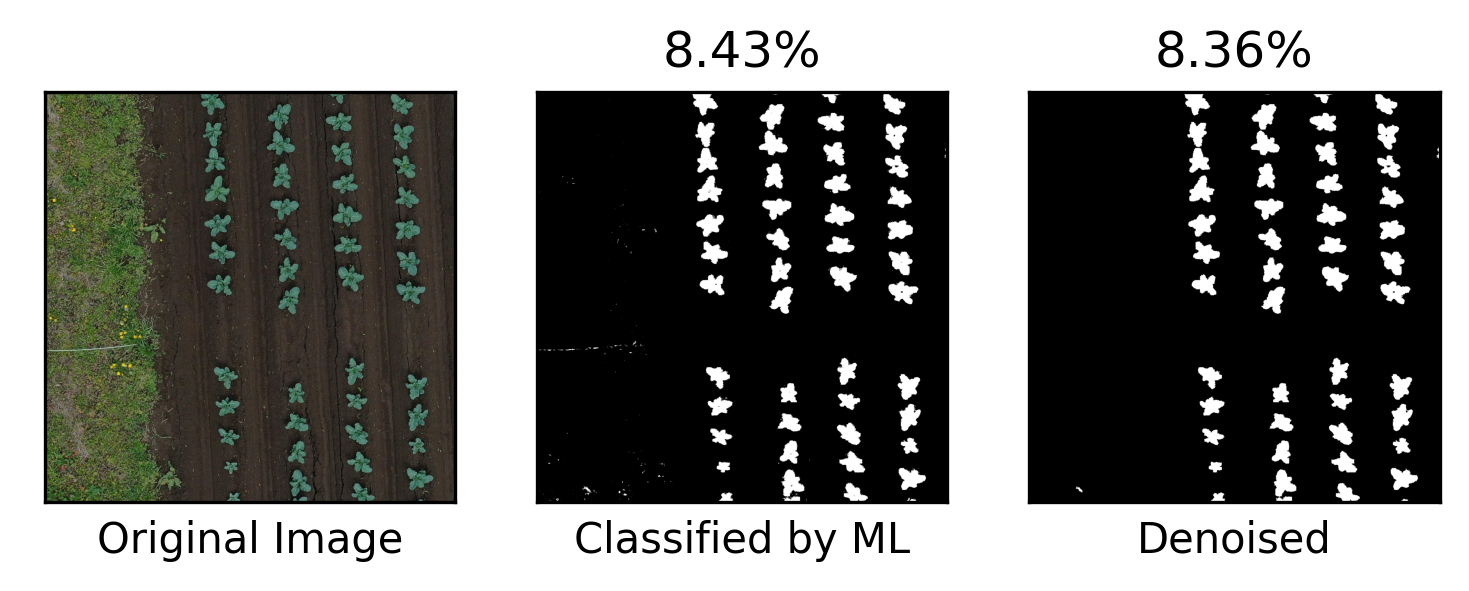

(8.43, 8.36)

In [28]:
course.supervise_machine_learning('ccexample/broccoli/200421_11_DJI_0402.JPG', "ccexample/broccoli/200421_11_DJI_0402.csv", denoise="default")

### Try your own image

> 自分のイメージを試してみる

First, upload your own training data

> まず、自分の学習データをアップロードします

In [ ]:
uploaded = files.upload()

In [ ]:
uav_image = "path/your_uav_image.jpg"   # <- change the string here for image one
uav_train = "path/your_uav_train.csv"  # <- change the string here for image one

In [ ]:
course.supervise_machine_learning(uav_image, uav_train)

# Section 4: Broccoli coverage tracking through growth

> 第4章: ブロッコリーの成長過程における取材追跡

Retrieve target images and their corresponding annotations, and sort them by the UAV flight date

> ターゲット画像とそれに対応するアノテーションを取得し、UAVの飛行日順にソートする。


**Important**

Please rename all the images in the given folder like:

> 指定されたフォルダ内の画像をすべて次のようにリネームしてください。

* 200318_xxxx.JPG
* 200345_xxxx.JPG

In [29]:
folder_name = "ccexample/broccoli"
img_suffix = ".JPG"
save_path = "'broccoli_results"

In [30]:
entry_list = [entry for entry in os.scandir(folder_name) if entry.name.endswith(img_suffix)]
# sort list by flight date
entry_list = sorted(entry_list,key=lambda x:x.name.split('_')[0])

converages = []
clean_converages = []
for entry in tqdm(entry_list, total=len(entry_list)):
    uav_image = entry.path
    uav_train = entry.path.replace('.JPG', '.csv')
    converage, clean_converage = course.supervise_machine_learning(uav_image, uav_train, save=save_path)
    converages.append(converage)
    clean_converages.append(clean_converage)

# save to csv fle
df = {'img_name': [entry.name for entry in entry_list], 'img_path': [entry.path for entry in entry_list], 'result_path':[f'{save_path}/result_{entry.name}' for entry in entry_list], 'converages': converages, 'clean_converages': clean_converages}
df = pd.DataFrame(df)
df.to_csv(f'{save_path}/results.csv')

  0%|          | 0/5 [00:00<?, ?it/s]

|-- Training model time cost=0s
|==================================================>|100.0%| Cost=1s
|-- Training model time cost=0s
|==================================================>|100.0%| Cost=1s
|-- Training model time cost=0s
|==================================================>|100.0%| Cost=1s
|-- Training model time cost=0s
|==================================================>|100.0%| Cost=1s
|-- Training model time cost=0s
|==================================================>|100.0%| Cost=1s


Visuazlizing broccoli coverage tracking through growth

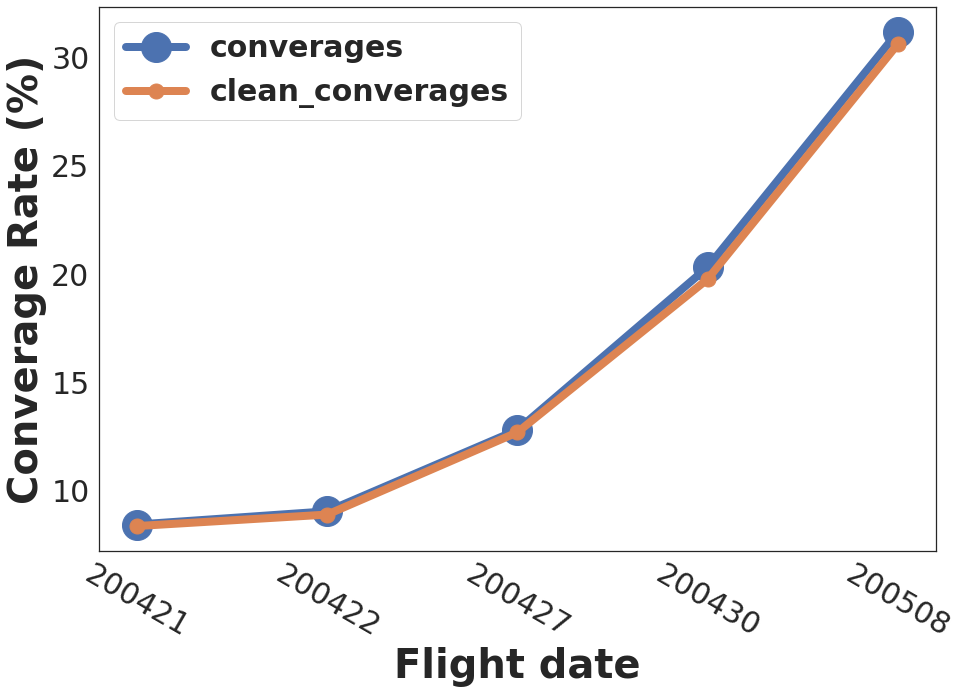

In [31]:
legendict={'size': 30, 'weight':'bold'}
label_font = {'size': 40, 'weight':'bold'}
linewidth = 8
markersize = 30
size = 30

sns.set_theme(style="white")
palette = sns.color_palette()

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111)

x = np.arange(len(entry_list))
labels = [entry.name.split('_')[0] for entry in entry_list]

ax.plot(x, converages, marker='o', label='converages', linewidth=linewidth,markersize=markersize, color=palette[0])
ax.plot(x, clean_converages, marker='.', label='clean_converages', linewidth=linewidth,markersize=markersize, color=palette[1])

plt.xticks(x, labels=labels, size=size, rotation=-30)
plt.yticks(size=size)
plt.xlabel("Flight date", fontdict=label_font)
plt.ylabel("Converage Rate (%)", fontdict=label_font)
plt.legend(prop=legendict)
plt.show()